# Introduction to NLP Fundamentals in TensorFlow

Natural Language Processing (NLP) is a field in machine learning with the ability of a computer to understand, interpret, and generate human language. NLP is a subset of artificial intelligence and is widely used in applications like language translation, chatbots, sentiment analysis, speech recognition, etc.

## Chech for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [2]:
import matplotlib.pyplot as plt

In [3]:
!nvidia-smi

Wed Oct 16 11:29:59 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| 26%   40C    P8             14W /  120W |     562MiB /   4096MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Get Helper Functions

In [4]:
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


## Get Data

In [5]:
import pandas as pd
train_df = pd.read_csv("data/train/train.csv")
test_df = pd.read_csv("data/test/test.csv")

## Visualizing Data

In [6]:
train_df.head(), test_df.head()

(   id keyword location                                               text  \
 0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
 1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
 2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
 3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
 4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   
 
    target  
 0       1  
 1       1  
 2       1  
 3       1  
 4       1  ,
    id keyword location                                               text
 0   0     NaN      NaN                 Just happened a terrible car crash
 1   2     NaN      NaN  Heard about #earthquake is different cities, s...
 2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
 3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
 4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan)

In [7]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [8]:
# Shuffle the training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
# Test data frame looks like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# Examples of each class
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [11]:
# Total number of samples
len(train_df), len(test_df)

(7613, 3263)

In [12]:
# Visualize the random training samples
import random
import matplotlib.pyplot as plt

random_index = random.randint(0, len(train_df)-5) # create random indexes not exceeding total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 1 (real disaster)
Text:
A new tropical cyclone is forming near Guam.

Once it is formed it will be called 'Molave'.

---

Target: 0 (not real disaster)
Text:
Ancient Mayan Tablet found via http://t.co/LmUMzkLtln http://t.co/yebxxAryBF http://t.co/SRRUqfffr6 http://t.co/CadzxAgMSI

---

Target: 0 (not real disaster)
Text:
3. excessive engine failure rate significant maintenance constantly emerging structural defects. Phew that's a lot I say.

---

Target: 1 (real disaster)
Text:
This is the first year the Forest Service spent more than half its annual budget on fighting fires. #climatechange http://t.co/D62zfZy0Mi

---

Target: 1 (real disaster)
Text:
Imagine a room with walls that are lava lamps.

---



### Split data into training and test sets

In [13]:
# Split the training data into training and validation sets
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [14]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [15]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

First step in working with text data is to convert them into numbers. There are few ways to do this:
* Tokenization - Direct mapping of token (a token could be a word or a character) to number.
* Embedding - Create a matrix of feature vector for each token (word) and use those vectors as features for the model.

### Text Vectorization (Tokenization)

In [16]:
train_sentences[:5], train_labels[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object),
 array([0, 0, 1, 0, 0], dtype=int64))

In [17]:

from tensorflow.keras.layers import TextVectorization
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization variables
text_vectorization = TextVectorization(max_tokens=10000, # Set max_tokens to a specific integer value
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None, # Create groups of n-words?
                                       output_mode="int", # How to map tokens to numbers
                                       output_sequence_length=None, # How long do you want your sequences to be
                                       pad_to_max_tokens=True)

In [18]:
len(train_sentences[0].split())

7

In [19]:
# Find the average number of tokens in the training data
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length of the sequence

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in the streets of New York"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 264,    3,  232,    4,    2, 1585,    6,   50,  913,    0,    0,
           0,    0,    0,    0]], dtype=int64)>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
ISIS claims responsibility for Saudi mosque suicide bombing http://t.co/Wpilp4mymf http://t.co/8NHD9iDaJs      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 543, 1091, 2745,   10,  312,  393,   87,  156,    1,    1,    0,
           0,    0,    0,    0]], dtype=int64)>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") # most common words
print(f"Bottom 5 least common words: {bottom_5_words}") # least common words

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [25]:
# Length of the vocabulary
len(words_in_vocab)

10000

## Creating an Embedding using an Embedding Layer

In [26]:
max_length

15

In [27]:
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length, # set input shape
                                      output_dim=128, # set size of embedding vector
                                      embeddings_initializer="uniform", # default initilization
                                      input_length=max_length) # how long is each input
embedding

In [28]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
The worst  voice I can ever hear is the 'Nikki your in trouble' voice from my mom      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03971504, -0.0495409 ,  0.04346852, ..., -0.00804331,
         -0.01827847, -0.01137704],
        [-0.04486055,  0.03499627, -0.00536363, ..., -0.04541416,
          0.01321376, -0.04569539],
        [-0.02556449,  0.0278378 ,  0.00967627, ..., -0.00189561,
         -0.00862938, -0.02787207],
        ...,
        [ 0.02560495, -0.04586787, -0.01867702, ..., -0.0204574 ,
          0.03844272,  0.0061137 ],
        [-0.02556449,  0.0278378 ,  0.00967627, ..., -0.00189561,
         -0.00862938, -0.02787207],
        [-0.04513955,  0.01091326,  0.04228255, ..., -0.02248303,
         -0.04155282, -0.01775597]]], dtype=float32)>

In [29]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.03971504, -0.0495409 ,  0.04346852, -0.00212915, -0.01200577,
       -0.04859258, -0.04638335,  0.04696903,  0.02986819,  0.02672087,
       -0.04542642, -0.0350984 ,  0.00212008, -0.02408137, -0.02694554,
       -0.0294016 ,  0.02693609,  0.01532818,  0.00445766, -0.00619947,
       -0.03783375,  0.04826387,  0.02276354, -0.03980042,  0.01788456,
        0.04706727, -0.00481606,  0.02491068, -0.03452582,  0.04699022,
        0.0058786 , -0.01384375,  0.02607739, -0.01061579, -0.02405105,
       -0.04237769, -0.03558876,  0.03196484, -0.02636085,  0.03570018,
        0.00504016,  0.01716173, -0.04234595,  0.00647129, -0.00930806,
       -0.04570727,  0.04662803, -0.02241135,  0.01043181, -0.03249275,
       -0.04481908, -0.01704096, -0.04156995, -0.03595246,  0.04589612,
        0.0416267 , -0.03989383, -0.00762738,  0.01421714, -0.04481889,
       -0.03525258,  0.03175077, -0.01248563,  0.03360114,  0.02283814,
        0.046733

## Modelling a text dataset (setting up modelling experiments)

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of the training data

Steps for each model:
1. Construct the model
2. Train the model
3. Make predictions
4. Track the results

### Model 0: Naive Bayes (baseline)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create Tokenization and Modelling Pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model accuracy: {baseline_score*100:.2f}%")

Baseline model accuracy: 79.27%


In [32]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

### Create an evaluation function for model experiments

Modelling experiments are typically evaluated using:
* Accuracy - the higher the better
* Precision - the higher the better
* Recall - the higher the better
* F1-score - the higher the better

In [33]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
        y_true: true labels in the form of a 1D array
        y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """

    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100 # get accuracy score in percentage
    # Calculate model precision, recall and f1 score using "weighted average"
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    # Create a dictionary of results
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1 score": model_f1}
    
    return model_results

In [34]:
# Get the baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1 score': 0.7862189758049549}

### Model 1: Feed-forward neural network (dense model)

In [35]:
# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [36]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [37]:
# Build a model using the Sequential API
from tensorflow.keras import layers
input = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(input) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector

output = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary output so use sigmoid activation function
model_1 = tf.keras.Model(input, output, name="model_1_dense") # construct the model

In [38]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_1_history = model_1.fit(train_sentences, train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20241016-113001
Epoch 1/5
215/215 [==============================] - 5s 17ms/step - loss: 0.6142 - accuracy: 0.6914 - val_loss: 0.5414 - val_accuracy: 0.7454
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4434 - accuracy: 0.8177 - val_loss: 0.4712 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3478 - accuracy: 0.8613 - val_loss: 0.4617 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 4s 16ms/step - loss: 0.2854 - accuracy: 0.8885 - val_loss: 0.4631 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2377 - accuracy: 0.9115 - val_loss: 0.4888 - val_accuracy: 0.7900


In [39]:
# Evaluate the model
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4888 - accuracy: 0.7900


[0.48875612020492554, 0.7900262475013733]

In [40]:
# Make predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.28891802],
       [0.8570126 ],
       [0.9975726 ],
       [0.08191413],
       [0.10381918],
       [0.9258567 ],
       [0.88871014],
       [0.99258786],
       [0.96224165],
       [0.20009117]], dtype=float32)

In [41]:
# Convert model_1 pred probs from probabilities to prediction labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [42]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [43]:
# Evaluate model_1 with evaluate function
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)

model_1_results

{'accuracy': 79.00262467191601,
 'precision': 0.7986440245389494,
 'recall': 0.7900262467191601,
 'f1 score': 0.7859832179841351}

In [44]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1 score': 0.7862189758049549}

In [45]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings

In [46]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()

len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [47]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [48]:
# Get the weight matrix of the embedding layer
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

In [49]:
import io

# Code to save trained embeddings to file - we got this from here: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

### Model 2: LSTM model

* LSTM (Long Short Term Memory) - one of the most popular LSTM cells. LSTM cells have the ability to "remember" things which are important in natural language processing tasks.

In [50]:
# Create LSTM model
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(f"After embedding: {x.shape}")


x = layers.LSTM(64, activation="tanh")(x)
print(f"After LSTM cellL {x.shape}")

outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

After embedding: (None, 15, 128)
After LSTM cellL (None, 64)


In [51]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20241016-113024
Epoch 1/5
215/215 [==============================] - 11s 29ms/step - loss: 0.2221 - accuracy: 0.9212 - val_loss: 0.5043 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1554 - accuracy: 0.9409 - val_loss: 0.6110 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.1301 - accuracy: 0.9492 - val_loss: 0.6243 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.1064 - accuracy: 0.9607 - val_loss: 0.6943 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0868 - accuracy: 0.9650 - val_loss: 0.7425 - val_accuracy: 0.7703


In [52]:
# Make predictions
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


((762, 1),
 array([[0.02489586],
        [0.8026455 ],
        [0.9992683 ],
        [0.10699368],
        [0.00124199],
        [0.96644694],
        [0.40446305],
        [0.99943876],
        [0.99937904],
        [0.49032447]], dtype=float32))

In [53]:
# Round out pred probs and reduce to 1-dim array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [54]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)

model_2_results

{'accuracy': 77.03412073490814,
 'precision': 0.7718252603398367,
 'recall': 0.7703412073490814,
 'f1 score': 0.7683227325217538}

### Model 3: GRU mdoel

* GRU (Gated Recurrent Unit) - a variation of the LSTM cell but with less parameters.

In [55]:
# Build a RNN using the GRU cell
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, activation="tanh", return_sequences=True)(x) # return_sequences=True is required for stacking recurrent cells
# print(x.shape)
x = layers.GRU(64, activation="tanh")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_2_GRU")

In [56]:
# Model Summary
model_3.summary()

Model: "model_2_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [57]:
# Compile the model_3
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model_3
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20241016-113055
Epoch 1/5
215/215 [==============================] - 9s 28ms/step - loss: 0.1502 - accuracy: 0.9426 - val_loss: 0.8794 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0812 - accuracy: 0.9696 - val_loss: 0.9272 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0726 - accuracy: 0.9731 - val_loss: 0.9347 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0679 - accuracy: 0.9733 - val_loss: 0.9727 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0583 - accuracy: 0.9753 - val_loss: 1.0506 - val_accuracy: 0.7782


In [58]:
# Make predictions with model_3
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10], model_3_pred_probs.shape

24/24 [==============================] - 1s 4ms/step


(array([[2.2117095e-03],
        [6.2240177e-01],
        [9.9990207e-01],
        [2.1316718e-02],
        [2.3604531e-04],
        [9.9951530e-01],
        [7.0896173e-01],
        [9.9996144e-01],
        [9.9990803e-01],
        [4.8417652e-01]], dtype=float32),
 (762, 1))

In [59]:
# Convert model_3 preds probs into labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [60]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.82152230971128,
 'precision': 0.7810722984564322,
 'recall': 0.7782152230971129,
 'f1 score': 0.7757459581978545}

### Model 4: Bidirectional-LSTM model

In [61]:
# Build a model with bidrrectional RNN in TensorFlow
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)

x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [62]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [63]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20241016-113126
Epoch 1/5
215/215 [==============================] - 12s 32ms/step - loss: 0.1078 - accuracy: 0.9670 - val_loss: 0.9482 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0559 - accuracy: 0.9784 - val_loss: 1.2313 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0463 - accuracy: 0.9791 - val_loss: 1.3486 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0413 - accuracy: 0.9809 - val_loss: 1.3369 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0446 - accuracy: 0.9801 - val_loss: 1.4636 - val_accuracy: 0.7638


In [64]:
# Make predictions with model_4
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10], model_4_pred_probs.shape

24/24 [==============================] - 1s 5ms/step


(array([[3.5377888e-03],
        [7.6891071e-01],
        [9.9996978e-01],
        [7.3083229e-02],
        [2.5641304e-05],
        [9.9895060e-01],
        [2.5077069e-01],
        [9.9998927e-01],
        [9.9997312e-01],
        [9.9577624e-01]], dtype=float32),
 (762, 1))

In [65]:
# Convert pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [66]:
# Calculate model_4 results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'precision': 0.7638046232237288,
 'recall': 0.7637795275590551,
 'f1 score': 0.7625889751874003}

### Model 5: 1D Convolutional Neural Network

In [67]:
# Test to understand what things look like in Conv1D layer
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d_layer = layers.Conv1D(filters=32,
                              kernel_size=5, # setting this to 5 means it'll look at 5 words at a time, 3 would mean 3 words at a time
                              activation="relu")
conv_1d_output = conv_1d_layer(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
print(f"Embedding output shape: {embedding_test.shape}")
print(f"Conv1D output shape: {conv_1d_output.shape}")
print(f"Max pool output shape: {max_pool_output.shape}")

Embedding output shape: (1, 15, 128)
Conv1D output shape: (1, 11, 32)
Max pool output shape: (1, 32)


In [68]:
# the outputs of each layer
print(f"Embedding output: {embedding_test}")
print(f"Conv1D output: {conv_1d_output}")
print(f"Max pool output: {max_pool_output}")

Embedding output: [[[ 0.02651977  0.02018269 -0.07743363 ...  0.00445093 -0.02150951
   -0.07523359]
  [ 0.04031622 -0.02113115  0.01728627 ...  0.0515223  -0.03638303
   -0.04478361]
  [-0.0325738   0.0153787   0.00937999 ...  0.00719405 -0.06436022
   -0.08531646]
  ...
  [ 0.00610882  0.02215364 -0.0353632  ... -0.00304744  0.00132309
   -0.01143377]
  [ 0.00610882  0.02215364 -0.0353632  ... -0.00304744  0.00132309
   -0.01143377]
  [ 0.00610882  0.02215364 -0.0353632  ... -0.00304744  0.00132309
   -0.01143377]]]
Conv1D output: [[[0.01928791 0.05547646 0.         0.02349567 0.02549222 0.
   0.07075743 0.03232131 0.         0.         0.         0.07566359
   0.         0.         0.01074565 0.03142922 0.         0.
   0.         0.         0.02293313 0.         0.         0.01407429
   0.02405596 0.11169372 0.00364238 0.01068487 0.00551267 0.00028594
   0.01071792 0.        ]
  [0.02468107 0.01110977 0.         0.04562294 0.069979   0.
   0.         0.0042907  0.         0.       

In [69]:
# Build a model using 1D CNN
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)

x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)  # Reduced kernel size
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid", name="ouput_layer")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_CNN")

In [70]:
model_5.summary()

Model: "model_5_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 ouput_layer (Dense)         (None, 1)                 

In [71]:
# Compile the model_5
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model_5
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_CNN")])

Saving TensorBoard log files to: model_logs/model_5_CNN/20241016-113203
Epoch 1/5
215/215 [==============================] - 5s 17ms/step - loss: 0.1328 - accuracy: 0.9620 - val_loss: 0.8630 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0755 - accuracy: 0.9730 - val_loss: 1.0040 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0606 - accuracy: 0.9762 - val_loss: 1.1032 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0545 - accuracy: 0.9785 - val_loss: 1.1434 - val_accuracy: 0.7546
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0492 - accuracy: 0.9793 - val_loss: 1.2041 - val_accuracy: 0.7572


In [72]:
# Make prediction with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs.shape, model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


((762, 1),
 array([[6.1308973e-02],
        [7.0707142e-01],
        [9.9990129e-01],
        [3.9277494e-02],
        [9.7136876e-07],
        [9.9201107e-01],
        [9.6536607e-01],
        [9.9998063e-01],
        [9.9999899e-01],
        [8.3541203e-01]], dtype=float32))

In [73]:
# Convert pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [74]:
# Calculate model_5 results
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)

model_5_results

{'accuracy': 75.7217847769029,
 'precision': 0.7574646046920478,
 'recall': 0.7572178477690289,
 'f1 score': 0.7557133417830909}

### Model 6: TensorFlow Hub Pretrained Feature Extractor

In [75]:
sample_sentence

"There's a flood in the streets of New York"

In [76]:
import tensorflow_hub as hub
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# embed_samples = embed([sample_sentence,
#                        "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
# print(embed_samples[0][:50])


In [77]:
# embed_samples[0].shape

In [78]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

# Ceate a model using the Sequential API
from tensorflow.keras import layers
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid",
                 name="output_layer")
], name="model_6_USE")

# Compile the model_6
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Model_6 summary
model_6.summary()

In [79]:
# Ceate a model using the Sequential API
from tensorflow.keras import layers
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid",
                 name="output_layer")
], name="model_6_USE")

# Compile the model_6
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Model_6 summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [80]:
# Fit the model_6
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20241016-113232
Epoch 1/5
215/215 [==============================] - 7s 10ms/step - loss: 0.5056 - accuracy: 0.7808 - val_loss: 0.4549 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4151 - accuracy: 0.8143 - val_loss: 0.4394 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4008 - accuracy: 0.8224 - val_loss: 0.4352 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3931 - accuracy: 0.8263 - val_loss: 0.4327 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3852 - accuracy: 0.8313 - val_loss: 0.4277 - val_accuracy: 0.8136


In [81]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[0.28891802],
       [0.8570126 ],
       [0.9975726 ],
       [0.08191413],
       [0.10381918],
       [0.9258567 ],
       [0.88871014],
       [0.99258786],
       [0.96224165],
       [0.20009117]], dtype=float32)

In [82]:
# Convert predicton probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [83]:
# Calculate model_6 results
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)

model_6_results

{'accuracy': 81.36482939632546,
 'precision': 0.8137644815279499,
 'recall': 0.8136482939632546,
 'f1 score': 0.8130185559585642}

In [84]:
# Check for tensorflow gpu availability
print(tf.config.list_physical_devices("GPU"))

[]


### Model 7: Same as model 6 with 10% of the training data

#### NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET 

Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_10_percent.head(), len(train_10_percent)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

In [85]:
# Make 10% data split
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [86]:
# Check number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
Name: count, dtype: int64

In [87]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [88]:
# Build model_7 same as model_6
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_7_USE")

# Compile the model_7
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a model_7 summery
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [89]:
# Fit the model_7 with 10% data split
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,

                                                                     "tf_hub_sentence_ecoder_10_percent_correct_spilt")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_ecoder_10_percent_correct_spilt/20241016-113246
Epoch 1/5
22/22 [==============================] - 4s 42ms/step - loss: 0.6734 - accuracy: 0.6482 - val_loss: 0.6468 - val_accuracy: 0.7520
Epoch 2/5
22/22 [==============================] - 0s 15ms/step - loss: 0.6008 - accuracy: 0.8131 - val_loss: 0.5892 - val_accuracy: 0.7690
Epoch 3/5
22/22 [==============================] - 0s 15ms/step - loss: 0.5244 - accuracy: 0.8175 - val_loss: 0.5331 - val_accuracy: 0.7861
Epoch 4/5
22/22 [==============================] - 0s 15ms/step - loss: 0.4621 - accuracy: 0.8190 - val_loss: 0.5025 - val_accuracy: 0.7835
Epoch 5/5
22/22 [==============================] - 0s 15ms/step - loss: 0.4201 - accuracy: 0.8321 - val_loss: 0.4887 - val_accuracy: 0.7861


In [90]:
# Make predictions with the model_7
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[0.1888037 ],
       [0.5827515 ],
       [0.92235136],
       [0.38098192],
       [0.5570362 ],
       [0.6806969 ],
       [0.8921712 ],
       [0.78996825],
       [0.84216595],
       [0.12167007]], dtype=float32)

In [91]:
# Convert pred probs to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
# Calculate model_7 results
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)

model_7_results

{'accuracy': 78.60892388451444,
 'precision': 0.7874601430270979,
 'recall': 0.7860892388451444,
 'f1 score': 0.7844405481342521}

### Comparing the performance of each of our models

In [95]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1 score
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,79.002625,0.798644,0.790026,0.785983
2_lstm,77.034121,0.771825,0.770341,0.768323
3_gru,77.821522,0.781072,0.778215,0.775746
4_bidirectional,76.377953,0.763805,0.763780,0.762589
5_conv1d,75.721785,0.757465,0.757218,0.755713
6_tf_hub_use_encoder,81.364829,0.813764,0.813648,0.813019
7_tf_hub_use_encoder_10_percent,78.608924,0.787460,0.786089,0.784441


In [96]:
# Convert the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1 score
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.790026,0.798644,0.790026,0.785983
2_lstm,0.770341,0.771825,0.770341,0.768323
3_gru,0.778215,0.781072,0.778215,0.775746
4_bidirectional,0.763780,0.763805,0.763780,0.762589
5_conv1d,0.757218,0.757465,0.757218,0.755713
6_tf_hub_use_encoder,0.813648,0.813764,0.813648,0.813019
7_tf_hub_use_encoder_10_percent,0.786089,0.787460,0.786089,0.784441


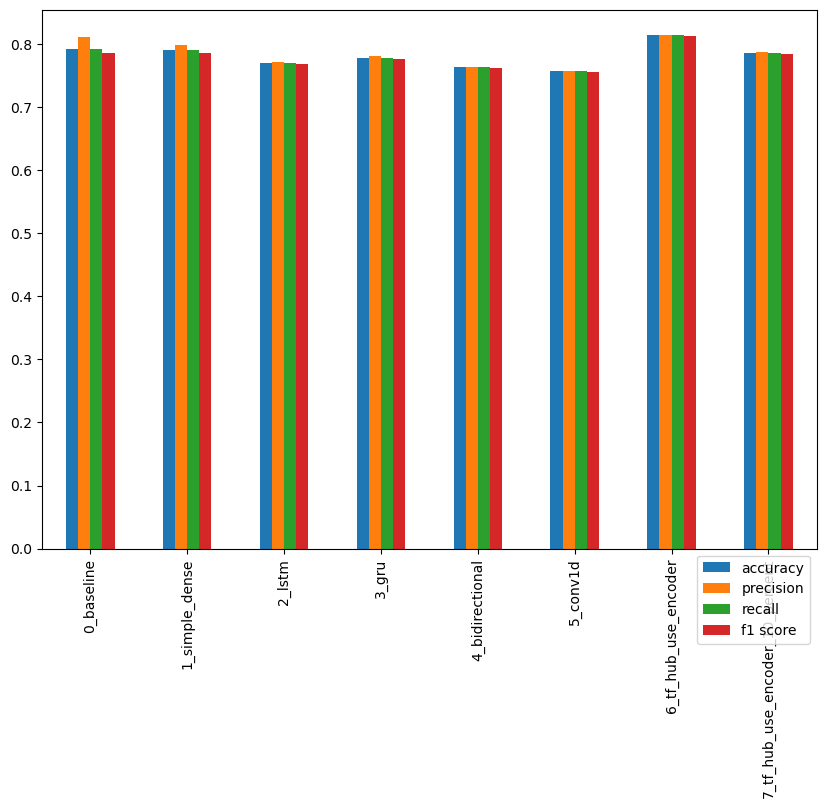

In [97]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 0));

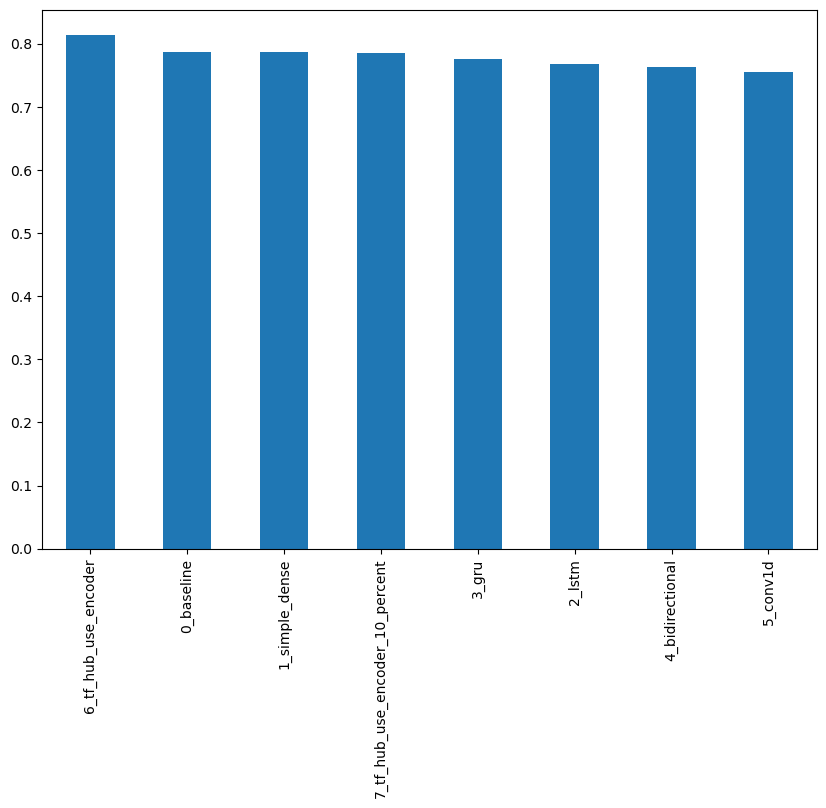

In [99]:
# Slot model results by f1-score
all_model_results.sort_values("f1 score", ascending=False)["f1 score"].plot(kind="bar", figsize=(10, 7));